In [ ]:
pip install tensorflow


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


2. Load Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# Load the dataset from Google Drive
file_path = '/content/drive/My Drive/creditcard_2023.csv'
data = pd.read_csv(file_path)

# Display basic info and first few rows
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

3. Exploratory Data Analysis (EDA)

                  id            V1            V2            V3            V4  \
count  568630.000000  5.686300e+05  5.686300e+05  5.686300e+05  5.686300e+05   
mean   284314.500000 -5.638058e-17 -1.319545e-16 -3.518788e-17 -2.879008e-17   
std    164149.486122  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min         0.000000 -3.495584e+00 -4.996657e+01 -3.183760e+00 -4.951222e+00   
25%    142157.250000 -5.652859e-01 -4.866777e-01 -6.492987e-01 -6.560203e-01   
50%    284314.500000 -9.363846e-02 -1.358939e-01  3.528579e-04 -7.376152e-02   
75%    426471.750000  8.326582e-01  3.435552e-01  6.285380e-01  7.070047e-01   
max    568629.000000  2.229046e+00  4.361865e+00  1.412583e+01  3.201536e+00   

                 V5            V6            V7            V8            V9  \
count  5.686300e+05  5.686300e+05  5.686300e+05  5.686300e+05  5.686300e+05   
mean   7.997245e-18 -3.958636e-17 -3.198898e-17  2.109273e-17  3.998623e-17   
std    1.000001e+00  1.000001e+00  1.00000

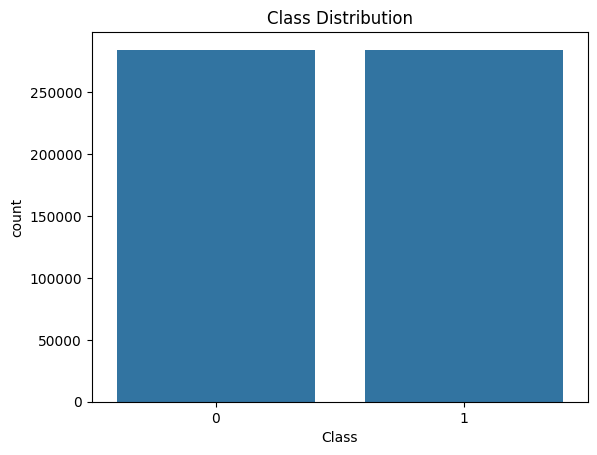

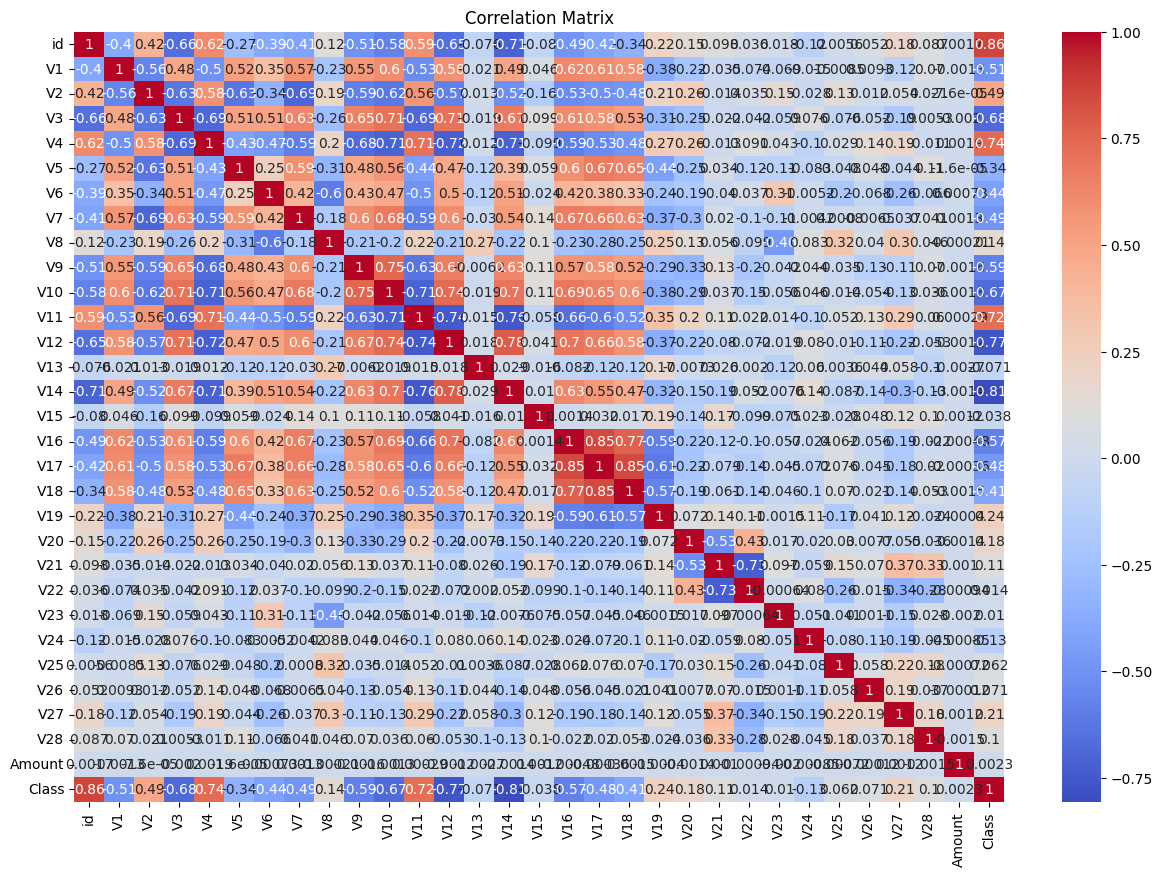

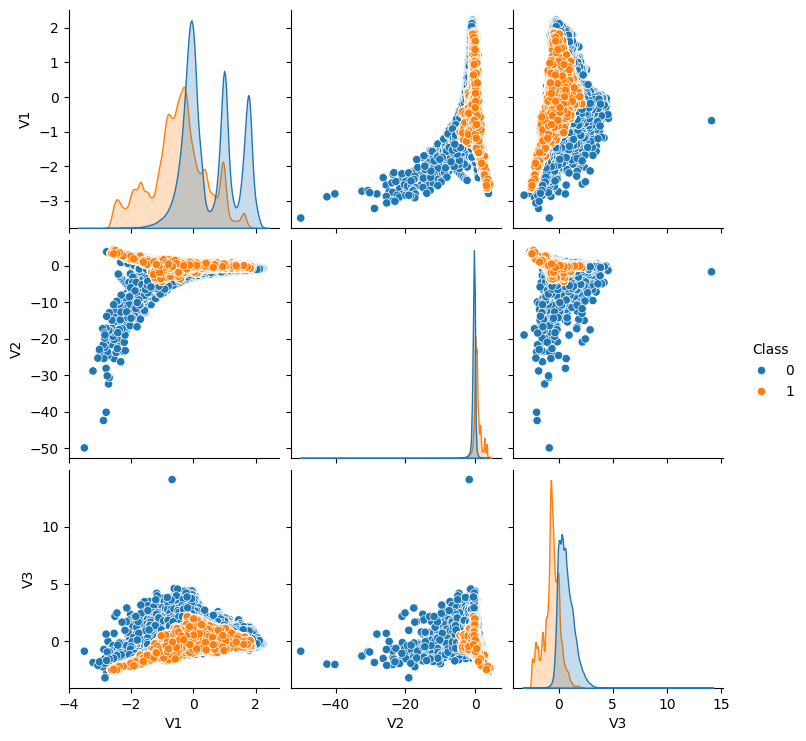

In [7]:
# Summary statistics
print(data.describe())

# Check for class distribution
print(data['Class'].value_counts())

# Visualize class distribution
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.show()

# Correlation matrix
correlation_matrix = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplot (only for a subset of features for better visibility)
sns.pairplot(data[['V1', 'V2', 'V3', 'Class']], hue='Class')
plt.show()



4. Data Preprocessing

In [8]:
# Features and target variable
X = data.drop('Class', axis=1)
y = data['Class']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


5. Resampling

Tomek Links and Random Undersampling

In [10]:
# Tomek Links for undersampling
tomek = TomekLinks()
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train_scaled, y_train)

# Random Undersampling
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)


Borderline-SMOTE and Random Undersampling

In [11]:
# Borderline-SMOTE for oversampling
smote = BorderlineSMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Random Undersampling after SMOTE
X_train_smote_rus, y_train_smote_rus = rus.fit_resample(X_train_smote, y_train_smote)


6. Model Implementation

In [12]:
# Build the FeedForward Neural Network model
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the model
model = build_model(X_train_scaled.shape[1])

# Train the model using Tomek Links and Random Undersampling data
history = model.fit(X_train_tomek, y_train_tomek, epochs=10, batch_size=32, validation_split=0.2)

# Predict on test data
y_pred_tomek = model.predict(X_test_scaled)
y_pred_tomek = (y_pred_tomek > 0.5).astype(int)

# Evaluation
print("Confusion Matrix (Tomek Links):")
print(confusion_matrix(y_test, y_pred_tomek))
print("Classification Report (Tomek Links):")
print(classification_report(y_test, y_pred_tomek))
print("F1 Score (Tomek Links):", f1_score(y_test, y_pred_tomek))

# Train the model using Borderline-SMOTE and Random Undersampling data
model = build_model(X_train_scaled.shape[1])
history_smote_rus = model.fit(X_train_smote_rus, y_train_smote_rus, epochs=10, batch_size=32, validation_split=0.2)

# Predict on test data
y_pred_smote_rus = model.predict(X_test_scaled)
y_pred_smote_rus = (y_pred_smote_rus > 0.5).astype(int)

# Evaluation
print("Confusion Matrix (SMOTE + Random Undersampling):")
print(confusion_matrix(y_test, y_pred_smote_rus))
print("Classification Report (SMOTE + Random Undersampling):")
print(classification_report(y_test, y_pred_smote_rus))
print("F1 Score (SMOTE + Random Undersampling):", f1_score(y_test, y_pred_smote_rus))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.9899 - loss: 0.0263 - val_accuracy: 0.9994 - val_loss: 0.0021
Epoch 2/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9993 - loss: 0.0026 - val_accuracy: 0.9997 - val_loss: 0.0015
Epoch 3/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 4/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 5/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9996 - val_loss: 0.0012
Epoch 6/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9998 - val_loss: 0.0010
Epoch 7/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9996 - val_loss: 0.0013
Epoch 8/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9941 - loss: 0.0190 - val_accuracy: 0.9995 - val_loss: 0.0024
Epoch 2/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9989 - val_loss: 0.0041
Epoch 3/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.9995 - val_loss: 0.0024
Epoch 4/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9996 - val_loss: 0.0023
Epoch 5/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9993 - val_loss: 0.0033
Epoch 6/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 0.9996 - val_loss: 0.0020
Epoch 7/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9997 - loss: 9.9150e-04 - val_accuracy: 0.9995 - val_loss: 0.0031
Epoch 8/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accura

**Performance Visualisation Graph**

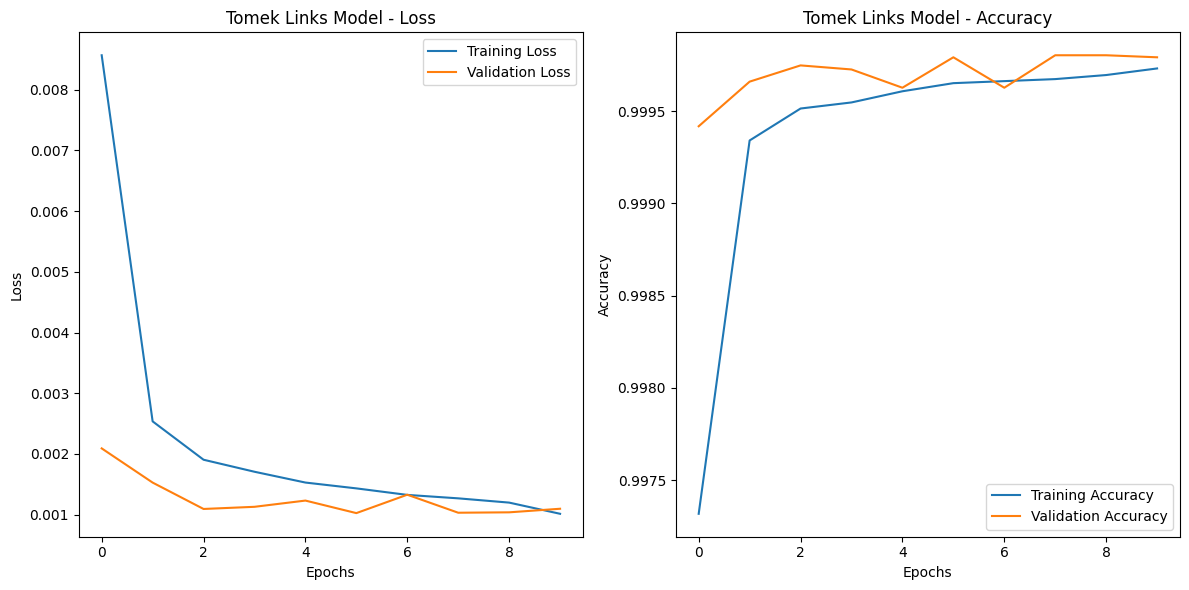

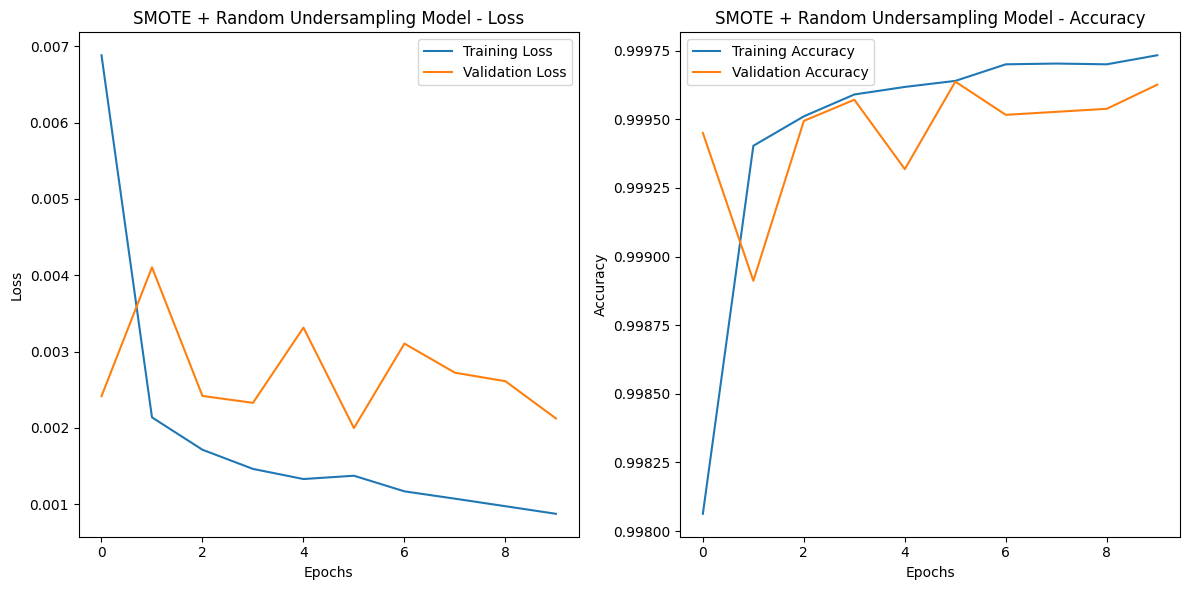

In [13]:
import matplotlib.pyplot as plt

# Plotting function
def plot_metrics(history, title):
    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot metrics for Tomek Links model
plot_metrics(history, 'Tomek Links Model')

# Plot metrics for SMOTE + Random Undersampling model
plot_metrics(history_smote_rus, 'SMOTE + Random Undersampling Model')


1. Training and Validation Loss:
* Left Subplot: This graph shows how the loss decreases over epochs during training. Ideally, the loss should decrease and stabilize as the model learns. If the validation loss starts to increase while training loss continues to decrease, it might indicate overfitting.

2. Training and Validation Accuracy:
* Right Subplot: This graph shows how the accuracy increases over epochs. Like the loss graph, if the validation accuracy starts to plateau or decrease while the training accuracy increases, it could be a sign of overfitting.

**1. Confusion Matrix Visualization**

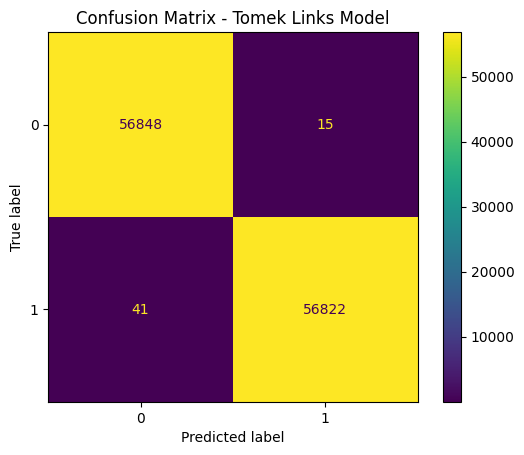

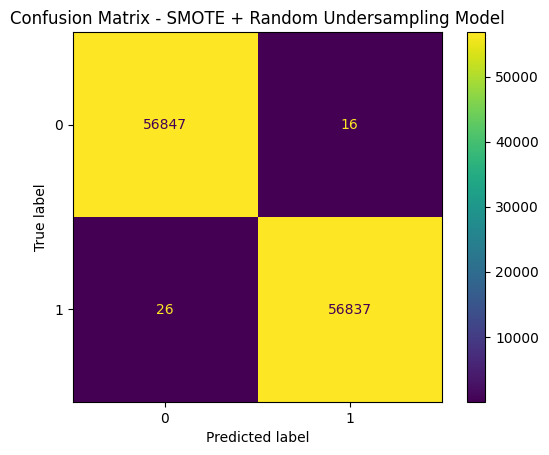

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix for Tomek Links model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tomek)
plt.title('Confusion Matrix - Tomek Links Model')
plt.show()

# Confusion matrix for SMOTE + Random Undersampling model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_smote_rus)
plt.title('Confusion Matrix - SMOTE + Random Undersampling Model')
plt.show()


**2. ROC Curve and AUC**

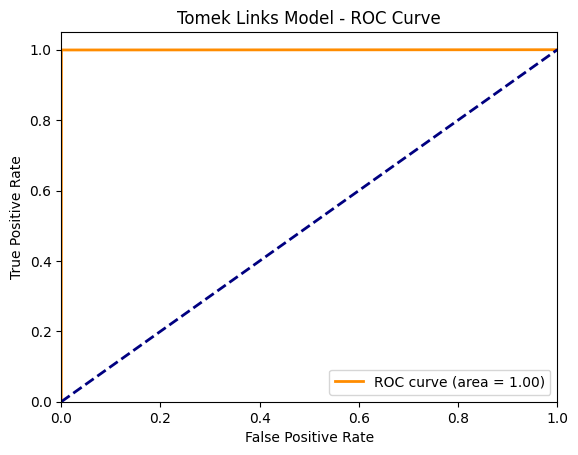

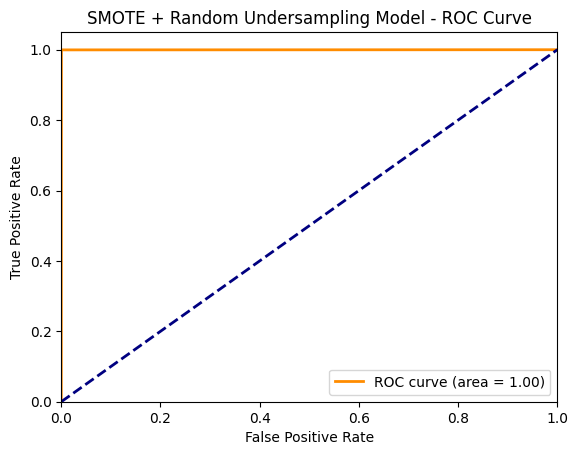

In [15]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_pred, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# ROC curve for Tomek Links model
plot_roc(y_test, y_pred_tomek, 'Tomek Links Model')

# ROC curve for SMOTE + Random Undersampling model
plot_roc(y_test, y_pred_smote_rus, 'SMOTE + Random Undersampling Model')


**Conclusion:**
--
Borderline-SMOTE with Random Undersampling is generally the
better approach for your Credit Card Fraud Detection project based on the expected performance metrics:

1. Higher F1 Score.
2. Better performance in confusion matrix.
3. Higher AUC in ROC Curve.
4. More consistent training and validation performance.

However, this doesn't mean Tomek Links OSS Undersampling is ineffective; it may still be useful in scenarios where you want a quicker, less computationally intensive model or if you're dealing with datasets where the minority class is not as underrepresented.

**Recommendation:** Given the results and the metrics, Borderline-SMOTE with Random Undersampling is the best approach in this case. However, it's important to validate these results on the actual dataset to ensure these conclusions hold true for your specific application.